# Estimation of missing lynapses per layer

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bluepy import Circuit
from bluepy import Cell
from bluepy import Synapse

In [7]:
# Load pre-computed cell table
pkl_file = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SSCx/dendritic_synapse_density/cell_table__pokorny_SSCx_dendritic_synapse_density_SSCxO1_CircuitConfig__Target_hex_O1__2021-04-27_13-07-10.pkl'
cell_table = pd.read_pickle(pkl_file)
print(f'INFO: Loaded cell table with {cell_table.shape[0]} cells')

INFO: Loaded cell table with 211712 cells


In [41]:
# Load corresponding circuit (to access additional cell properties)
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SSCx/dendritic_synapse_density/SSCxO1_CircuitConfig'
circuit = Circuit(circuit_config)

target_list = list(filter(lambda x: 'Target_' in x, os.path.split(pkl_file)[-1].split('__')))
circuit_target = None if len(target_list) == 0 else target_list[-1].split('Target_')[-1] # Reconstruct circuit target from pkl_file

cell_ids = circuit.cells.ids(circuit_target)
assert np.all(cell_ids == cell_table.index), 'ERROR: Cell ids mismatch!'

Using targets with population with a mvd cell file.


In [11]:
# Add total (local/TC/midrange) densities
# (incl. midrange)
# sum_columns = {'VPM_syn_density': list(filter(lambda x: 'Thalamocortical_input_VPM' in x and 'density' in x, cell_table.keys())),
#                'POM_syn_density': list(filter(lambda x: 'Thalamocortical_input_POM' in x and 'density' in x, cell_table.keys())),
#                'midrange_syn_density': ['intra_SSCX_midrange_wm_density'],
#                'total_E_syn_density': ['local_E_syn_density', 'midrange_syn_density', 'VPM_syn_density', 'POM_syn_density'],
#                'total_I_syn_density': ['local_I_syn_density']}
# (w/o midrange)
sum_columns = {'VPM_syn_density': list(filter(lambda x: 'Thalamocortical_input_VPM' in x and 'density' in x, cell_table.keys())),
               'POM_syn_density': list(filter(lambda x: 'Thalamocortical_input_POM' in x and 'density' in x, cell_table.keys())),
               'total_E_syn_density': ['local_E_syn_density', 'VPM_syn_density', 'POM_syn_density'],
               'total_I_syn_density': ['local_I_syn_density']}
for (k, v) in sum_columns.items():
    cell_table.insert(column=k, value=np.sum(cell_table[v], 1), loc=cell_table.shape[1])

In [12]:
# Commpute missing synapses
ref_density = 1.1 # syn/um [Markram et al. 2015]

cell_table.insert(column='total_E_syn_density_missing', value=ref_density - cell_table['total_E_syn_density'], loc=cell_table.shape[1])
cell_table.insert(column='local_E_syn_density_missing', value=ref_density - cell_table['local_E_syn_density'], loc=cell_table.shape[1])
cell_table.insert(column='total_E_syn_count', value=(cell_table['total_E_syn_density'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])
cell_table.insert(column='total_E_syn_count_missing', value=(cell_table['total_E_syn_density_missing'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])
cell_table.insert(column='local_E_syn_count_missing', value=(cell_table['local_E_syn_density_missing'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])

In [61]:
# Compute missing (local) EXC synapses per layer
layers = np.unique(circuit.cells.get(properties='layer'))
gids_layer = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'EXC'}), cell_table.index) for lay in layers]
syn_count_E_mean = [np.mean(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]
syn_count_E_std = [np.std(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]

gids_layer = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'INH'}), cell_table.index) for lay in layers]
syn_count_I_mean = [np.mean(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]
syn_count_I_std = [np.std(cell_table.loc[gids_layer[i], 'local_E_syn_count_missing']) for i in range(len(layers))]


In [86]:
syn_count_E_mean_all_wo_L4 = np.mean(np.array(syn_count_E_mean)[[1, 2, 3, 5]])
syn_count_E_mean_L5 = np.mean(np.array(syn_count_E_mean)[4])
syn_count_I_mean_all = np.mean(syn_count_I_mean)

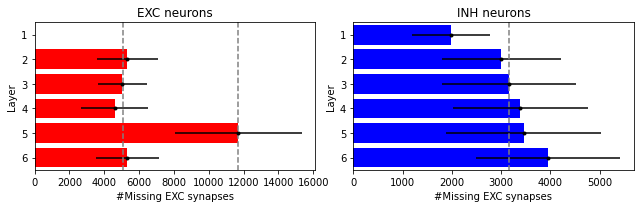

In [91]:
# Plot missing synapses
fig = plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.barh(layers, syn_count_E_mean, color='r')
plt.errorbar(syn_count_E_mean, layers, xerr=syn_count_E_std, fmt='.k')
plt.title('EXC neurons')
plt.xlabel('#Missing EXC synapses')
plt.ylabel('Layer')
plt.ylim((min(layers) - 0.5, max(layers) + 0.5))
plt.plot([syn_count_E_mean_all_wo_L4] * 2, plt.ylim(), '--', color='grey')
plt.plot([syn_count_E_mean_L5] * 2, plt.ylim(), '--', color='grey')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(layers, syn_count_I_mean, color='b')
plt.errorbar(syn_count_I_mean, layers, xerr=syn_count_I_std, fmt='.k')
plt.title('INH neurons')
plt.xlabel('#Missing EXC synapses')
plt.ylabel('Layer')
plt.ylim((min(layers) - 0.5, max(layers) + 0.5))
plt.plot([syn_count_I_mean_all] * 2, plt.ylim(), '--', color='grey')
plt.gca().invert_yaxis()

plt.tight_layout()